In [48]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import subprocess
import threading

In [49]:
# get current directory
WORK_DIR = os.getcwd()
print("Working directory:", WORK_DIR)

Working directory: /home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime


In [50]:
# Prometheus server URL
PROMETHEUS_URL = "http://192.168.122.115:32181"
# Prometheus query to fetch the metric in watts if greater than 0.01
QUERY = 'scaph_process_power_consumption_microwatts{container_scheduler="docker"} / 1000000 > 0.001'
# SAVE_FILE_PATH_DATA = f"{WORK_DIR}/data/pc-time-containers.json"
POD_DATA=f"{WORK_DIR}/data/all_pod_metrics.json"
UID_POD_MAPPING_PATH=f"{WORK_DIR}/data/uid_pod_mapping.csv"

In [51]:
def get_all_pod_names(save_path):
    command = ['kubectl', 'get', 'pods', '--all-namespaces','-ojson']
    # Open the result file in write mode
    with open(save_path, 'w') as f:
        # Run the command, redirecting stderr to /dev/null
        subprocess.run(command, stdout=f, stderr=subprocess.DEVNULL, check=True)

    print(f"List of pod names saved to '{save_path}'")

In [52]:
def get_pod_info(search_term):
    """Retrieve the pod name and namespace based on the search term."""
    try:
        # Get the output of the kubectl command to find the pod
        result = subprocess.run(
            ['kubectl', 'get', 'pods', '-A'],
            capture_output=True,
            text=True,
            check=True
        )
        
        # Parse the output to find the matching pod
        for line in result.stdout.splitlines()[1:]:  # Skip the header
            if search_term in line:
                parts = line.split()
                namespace = parts[0]
                pod_name = parts[1]
                return pod_name, namespace

        print("Pod not found.")
        return None, None
    except subprocess.CalledProcessError as e:
        print(f"Error executing kubectl: {e}")
        return None, None

def run_iperf(pod_name, namespace, mode, log_dir,duration=None,ip_address=None, mb=None, packet_length=None):
   
    # Set up log file path and header
    mode_suffix = 'client' if mode == 'client' else 'server'
    log_file = f"{log_dir}/log_iperf_{mode_suffix}_{pod_name}"
    if ip_address and mb:
        log_file += f"_{ip_address}_{mb}_{duration}_{packet_length}"
    log_file += ".csv"

    header = "Timestamp,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Interval,Transfer,Bitrate,Jitter,Lost_Packets,Lost_Packets_Percent,Unknown1,Unknown2"
    
    # Write the header to the log file
    with open(log_file, 'w') as f:
        f.write(header + '\n')

    try:
        # Construct the iperf command
        if mode == 'client':
            if not all([ip_address, mb, duration, packet_length]):
                raise ValueError("Client mode requires ip_address, value, duration, and packet_length parameters.")

            iperf_command = [
                'kubectl', 'exec', pod_name, '-n', namespace,
                '--', 'iperf', '-c', ip_address, '-u', '-i', '1',
                '-b', f"{mb}M", '-t', str(duration), '-l', str(packet_length), '--reportstyle', 'C'
            ]
        elif mode == 'server':
            iperf_command = [
                'kubectl', 'exec', pod_name, '-n', namespace,
                '--', 'iperf', '-s', '-u', '-i', '1', '-t', str(duration), '--reportstyle', 'C'
            ]
        else:
            raise ValueError("Mode must be either 'client' or 'server'.")

        # Print the command for debugging
        print("Running command:", iperf_command)

        # Open the log file in append mode
        with open(log_file, 'a') as f:
            # Run the iperf command, redirecting stderr to /dev/null
            subprocess.run(iperf_command, stdout=f, stderr=subprocess.DEVNULL, check=True)
        
        print(f"Log file saved to: {log_file}")

    except subprocess.CalledProcessError as e:
        print(f"Error executing iperf: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [53]:

def create_uid_pod_mapping(save_file_path, pod_list_path):
    # Load pod data from JSON file
    try:
        with open(pod_list_path, "r") as f:
            pod_data = json.load(f)
    except FileNotFoundError:
        print(f"{pod_list_path} not found. Please collect the pod metrics first.")
        return

    # Initialize a dictionary to map UIDs to pod names
    uid_pod_map = {}

    # Retrieve all UIDs and corresponding pod names
    for pod_info in pod_data.get("items", []):  # `items` is a list of pods
        metadata = pod_info.get("metadata", {})
        uid = metadata.get("uid")
        pod_name = metadata.get("name")

        if uid and pod_name:  # Check if both uid and name exist
            uid_pod_map[uid] = pod_name

    # Convert the mapping to a DataFrame
    uid_pod_df = pd.DataFrame(list(uid_pod_map.items()), columns=['UID', 'Pod Name'])

    # Print the DataFrame (optional)
    print(uid_pod_df)

    # Save the DataFrame to a CSV file
    uid_pod_df.to_csv(save_file_path, index=False)

In [54]:
def load_uid_pod_map(csv_file_path):
    """Loads UID to pod name mapping from a CSV file and returns it as a dictionary."""
    try:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path)
        # Create a dictionary mapping UIDs to pod names
        uid_pod_map = dict(zip(df['UID'], df['Pod Name']))
        return uid_pod_map
    except FileNotFoundError:
        print(f"{csv_file_path} not found.")
        return {}

In [55]:
def fetch_metrics():
    """Fetches metrics from Prometheus and returns a dictionary of values by container ID."""
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query", params={'query': QUERY})
    metrics_by_container = {}

    if response.status_code == 200:
        try:
            result = response.json()
            for entry in result['data']['result']:
                # Extract container_id and metric value
                container_id = entry['metric'].get('container_id', 'unknown')
                if container_id == "unknown":
                    print("unknown container id ",container_id)
                value = float(entry['value'][1])
                cmdline= entry['metric'].get('cmdline', 'unknown')
                timestamp = time.time()

                # Initialize list if container_id not in dictionary
                if container_id not in metrics_by_container:
                    metrics_by_container[container_id] = []
                
                # Append timestamped metric
                metrics_by_container[container_id].append({'timestamp': timestamp, 'value': value, 'cmdline':cmdline})
                
            return metrics_by_container
        except (IndexError, KeyError):
            print("Error parsing metrics.")
            return {}
    else:
        print(f"Failed to fetch metrics. Status code: {response.status_code}")
        return {}

def collect_metrics(duration,save_file_path):
    """Collects metrics for the specified duration and saves them to a JSON file."""
    metrics_over_time = {}
    start_time = time.time()

    while time.time() - start_time < duration:
        metrics = fetch_metrics()
        for container_id, data_points in metrics.items():
            if container_id not in metrics_over_time:
                metrics_over_time[container_id] = []
            metrics_over_time[container_id].extend(data_points)
        time.sleep(1)  # Collect every second

    # Save metrics to JSON file
    with open(save_file_path, "w") as f:
        json.dump(metrics_over_time, f)
    
    print(f"Metrics saved to '{save_file_path}'")
    f.close()

In [56]:
import matplotlib.pyplot as plt
import json
import matplotlib.ticker as ticker

def plot_metrics(file_path_data, save_file_path_plot, uid_pod_map, interval=2):
    """Reads metrics from the JSON file, downsamples to the specified interval, and plots them."""
    # Load data from JSON file
    try:
        with open(file_path_data, "r") as f:
            metrics_over_time = json.load(f)
    except FileNotFoundError:
        print(f"{file_path_data} not found. Please collect metrics first.")
        return

    plt.figure(figsize=(20, 10))

    # Plot each container's data with a unique color
    for container_id, container_data in metrics_over_time.items():
        downsampled_data = []
        last_timestamp = None
        
        # Initialize pod name with a default value
        pod_name = "unknown"  # Default value
        
        # Downsample the data to show points every `interval` seconds
        for entry in container_data:
            timestamp = entry['timestamp']
            value = entry['value']
            
            # Find the corresponding pod name from the uid_pod_map
            for uid, name in uid_pod_map.items():
                if uid.endswith(container_id):
                    pod_name = name  # Use the mapped pod name
                    break  # Exit loop once we find the match

            # Add the first data point or any data point at least `interval` seconds after the last
            if last_timestamp is None or (timestamp - last_timestamp) >= interval:
                downsampled_data.append((timestamp, value))
                last_timestamp = timestamp
        
        if pod_name == "unknown":
            print(container_id)

        # Normalize timestamps to start from 0
        if downsampled_data:
            min_timestamp = downsampled_data[0][0]
            normalized_times = [(t[0] - min_timestamp) for t in downsampled_data]
            values = [t[1] for t in downsampled_data]
            
            # Plot the downsampled data for this container using the pod name as label
            plt.plot(normalized_times, values, marker='o', linestyle='-', label=pod_name)

    # Set up precise y-axis ticks
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("Power Consumption (Watts)")
    plt.title("Power Consumption Over Time by Pod Name")
    
    # Adjust y-axis major ticks for precision (every 5 Watts, for example)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.05))  # Major ticks every 5 Watts
    
    # Add minor ticks (every 1 Watt) for finer granularity
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.005))
    
    # Optional: You can enable the grid on minor ticks if desired
    plt.grid(which='both', axis='y', linestyle='--', color='gray', alpha=0.7)
    
    # Position the legend
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.40), ncol=1)  # Centered at bottom
    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(save_file_path_plot)
    print(f"Plot saved as {save_file_path_plot}")


In [57]:
get_all_pod_names(POD_DATA)
create_uid_pod_mapping(UID_POD_MAPPING_PATH, POD_DATA)

List of pod names saved to '/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/data/all_pod_metrics.json'
                                     UID  \
0   88cd5dd3-19cc-466e-916f-a538cbe13991   
1   7519d970-f5fc-4611-95bd-26242caadc41   
2   7de8a3a9-456f-4d60-9e48-ff880fa78280   
3   ceeb38b8-e0ec-4d7c-8881-8295ef695f63   
4   e5339d5a-152d-4467-b0cb-3b9c68b10302   
5   0e0aca3c-2125-45f4-99c0-a6d94d44eeb9   
6   826ef148-2f01-4d38-9fe7-7efd140a20ae   
7   cd213474-7b44-402b-b567-2490f080f671   
8   1d94ff63-0a0d-4c3e-9098-c082775cf5f9   
9   0f2d51fb-58ae-41b2-a97e-f9fc73e8dc38   
10  bfa14fd4-5456-4021-9640-9f210bfc5e96   
11  2dbf5da3-b5e1-48ad-bd35-e02ce7a960c9   
12  7283d371-2aa6-461c-a99a-49bd7f27612c   
13  0c550ddc-5a87-4341-b401-976a5df98e17   
14  de78c56f-5e27-4d90-b069-f58f33eaaa05   
15  3cbf6f6b-5b7e-4674-af0d-c8fad9e072c5   
16  7d61ca44-61d2-4e46-a29b-5234f2f1eecf   
17  eaceef53-7ca0-45f8-9af4-3048862a81a6   
18  16023171-c6d6-4c59-a188-70422af432c7  

In [58]:
# Load the UID to pod mapping from the CSV file
uid_pod_map = load_uid_pod_map(UID_POD_MAPPING_PATH)  # Update this path to your actual CSV file
uid_pod_map

{'88cd5dd3-19cc-466e-916f-a538cbe13991': 'basic-mysql-5cb646b69b-stc4f',
 '7519d970-f5fc-4611-95bd-26242caadc41': 'oai-amf-644c76d868-s9t9s',
 '7de8a3a9-456f-4d60-9e48-ff880fa78280': 'oai-ausf-67fbc79586-phpt4',
 'ceeb38b8-e0ec-4d7c-8881-8295ef695f63': 'oai-flexric-74df96bd4b-vzg94',
 'e5339d5a-152d-4467-b0cb-3b9c68b10302': 'oai-lmf-7ccd476c55-x25pm',
 '0e0aca3c-2125-45f4-99c0-a6d94d44eeb9': 'oai-nrf-5d78cb6f94-c4h6v',
 '826ef148-2f01-4d38-9fe7-7efd140a20ae': 'oai-smf-85cdd6c9d-r5cbr',
 'cd213474-7b44-402b-b567-2490f080f671': 'oai-traffic-server-778dbdd8db-hl4j5',
 '1d94ff63-0a0d-4c3e-9098-c082775cf5f9': 'oai-udm-76f7f656df-fzjsw',
 '0f2d51fb-58ae-41b2-a97e-f9fc73e8dc38': 'oai-udr-7ff4584674-vknch',
 'bfa14fd4-5456-4021-9640-9f210bfc5e96': 'oai-upf-848596c864-2x4sw',
 '2dbf5da3-b5e1-48ad-bd35-e02ce7a960c9': 'grafana-65c99ddbc7-mvf9f',
 '7283d371-2aa6-461c-a99a-49bd7f27612c': 'power-metrics-per-pod-app-7d798d6b4c-pw4qs',
 '0c550ddc-5a87-4341-b401-976a5df98e17': 'prometheus-alertmanager-

In [ ]:
# create dir for log
mb=70
duration=60
packet_length=1300
LOG_DIR=f"{WORK_DIR}/data/{mb}_{duration}_{packet_length}"
os.makedirs(LOG_DIR,exist_ok=True)
SAVE_FILE_PATH_DATA=f"{LOG_DIR}/pc-time-containers.json"
SAVE_FILE_PATH_PLOT = f"{LOG_DIR}/pc-time-containers.png"

In [60]:
# iperf server (NR-UE)
search_term="oai-nr-ue"
pod_name, namespace = get_pod_info(search_term)
mode='server'
print("Run iperf server: ",pod_name,namespace,mode)

#pod_name, namespace, mode, ip_address=None, value=None, duration=None, packet_length=None
iperf_thread_server = threading.Thread(target=run_iperf, args=(pod_name, namespace,mode,LOG_DIR,duration))

# iperf client (UPF)
search_term="oai-upf"
pod_name, namespace = get_pod_info(search_term)
mode='client'
# mb=40
# duration=180
# packet_length=400
ip_address = '12.1.1.100'
print("Run iperf client: ",pod_name,namespace,mode,"mb",mb,"duration",duration,"ip address",ip_address)

iperf_thread_client = threading.Thread(target=run_iperf, args=(pod_name, namespace, mode,LOG_DIR,duration,ip_address, mb,packet_length))
metrics_thread = threading.Thread(target=collect_metrics, args=(duration,SAVE_FILE_PATH_DATA))

# Start both threads
iperf_thread_server.start()
iperf_thread_client.start()
metrics_thread.start()

# Wait for both threads to finish
iperf_thread_client.join()
iperf_thread_server.join()
metrics_thread.join()

Run iperf server:  oai-nr-ue-5d8fd5dfbc-c8vrf ran server
Run iperf client:  oai-upf-848596c864-2x4sw core client mb 70 duration 60 ip address 12.1.1.100
Running command: ['kubectl', 'exec', 'oai-nr-ue-5d8fd5dfbc-c8vrf', '-n', 'ran', '--', 'iperf', '-s', '-u', '-i', '1', '-t', '60', '--reportstyle', 'C']
Running command: ['kubectl', 'exec', 'oai-upf-848596c864-2x4sw', '-n', 'core', '--', 'iperf', '-c', '12.1.1.100', '-u', '-i', '1', '-b', '70M', '-t', '60', '-l', '700', '--reportstyle', 'C']
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  unknown
unknown container id  un

unknown
pod0fb36c5deb325d234f4edfcb79b99c2f
pode32c308132acc2a96da471048bbc4551
podbea7fecd033ebaf8b2ed0a68933a08bc
pod758968c0c4c3bb7949a499c77136cbb9
Plot saved as /home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/data/70_60_700/pc-time-containers.png


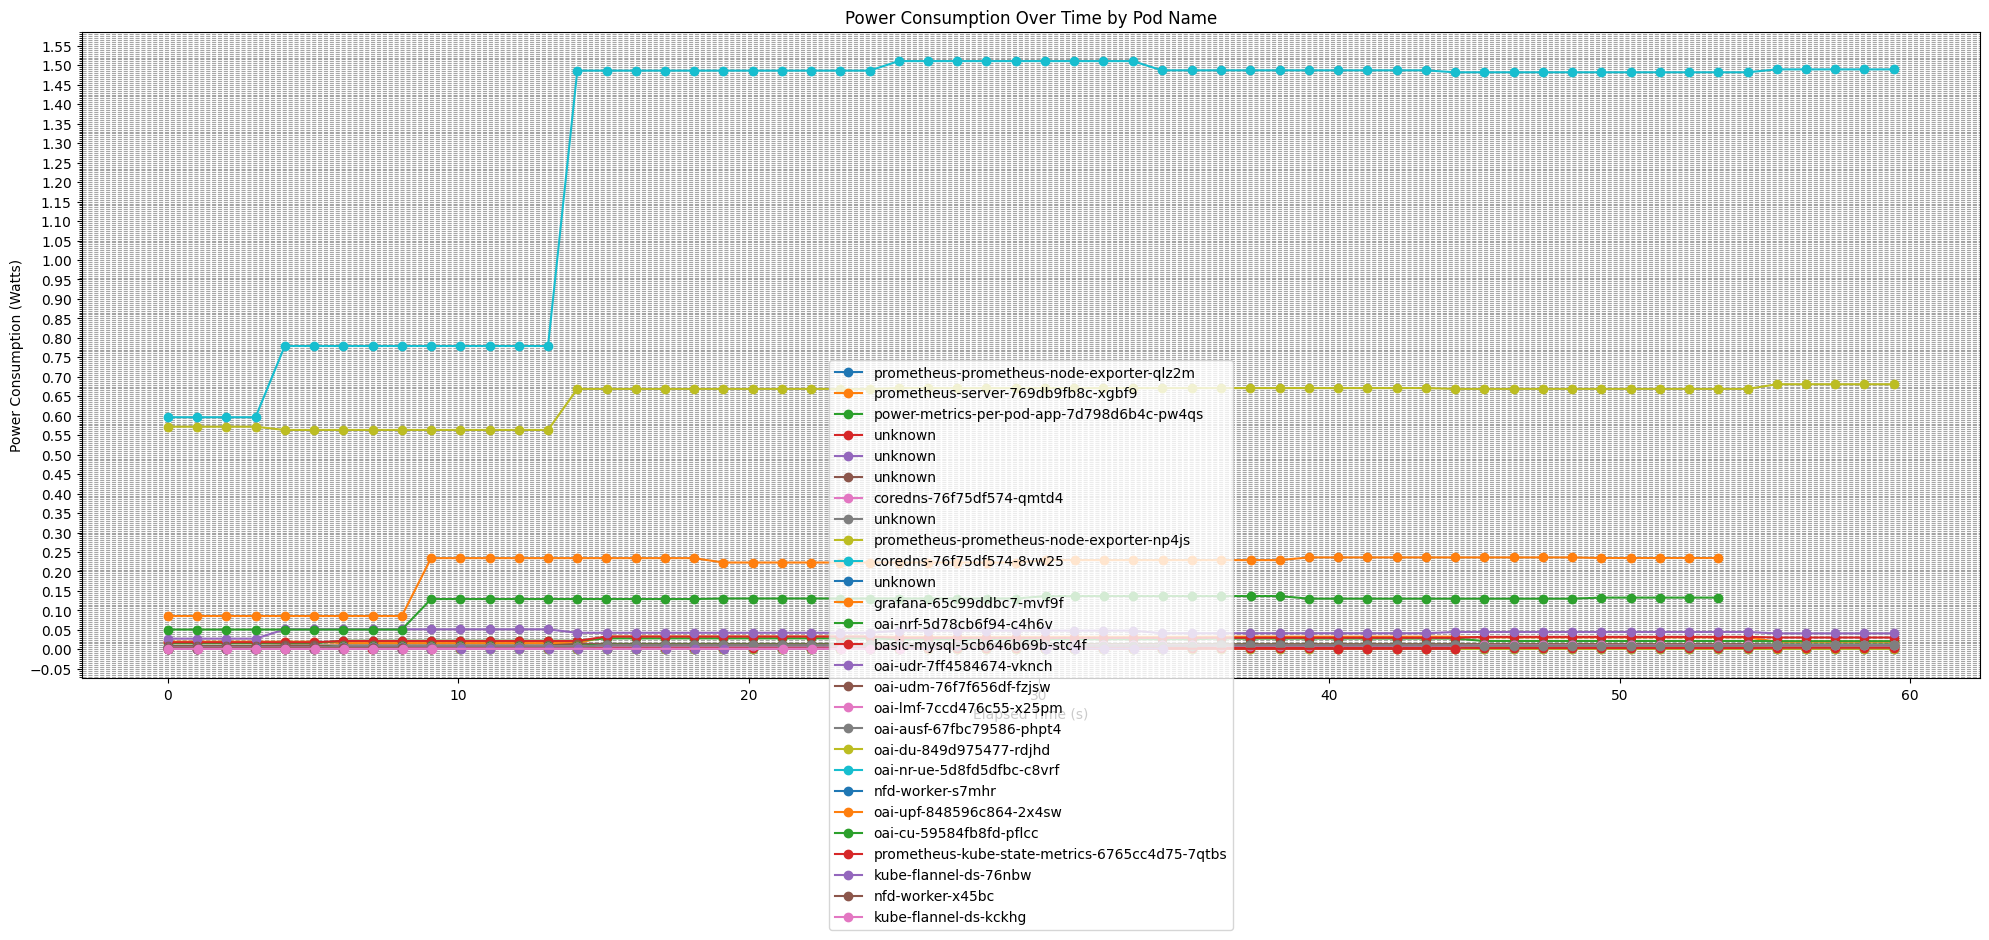

In [61]:
# Plot the metrics
plot_metrics(SAVE_FILE_PATH_DATA, SAVE_FILE_PATH_PLOT, interval=1, uid_pod_map=uid_pod_map)